# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import os
from urllib.request import urlretrieve

DATA_ZIP_PATH = 'traffic-signs-data.zip'

def download(url, file):
    if not os.path.isfile(file):
        urlretrieve(url, file)

download('https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip', DATA_ZIP_PATH)

In [2]:
from zipfile import ZipFile
import pickle

with ZipFile(DATA_ZIP_PATH) as zipf:
    with zipf.open('train.p') as f:
        train_dataset = pickle.load(f)
    with zipf.open('valid.p') as f:
        valid_dataset = pickle.load(f)
    with zipf.open('test.p') as f:
        test_dataset = pickle.load(f)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = len(train_dataset['labels'])

n_validation = len(valid_dataset['labels'])

n_test = len(test_dataset['labels'])

image_shape = train_dataset['features'][0].shape

image_dim = image_shape[0]

uniq_classes = set(train_dataset['labels']) | set(valid_dataset['labels']) | set(test_dataset['labels'])

n_classes = len(uniq_classes)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

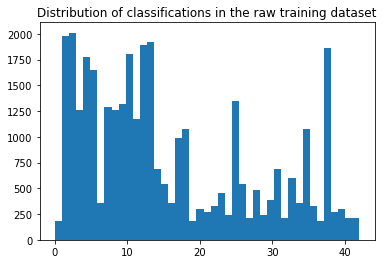

In [5]:
distro_classes, _, _ = plt.hist(train_dataset['labels'], bins=n_classes)
_ = plt.title('Distribution of classifications in the raw training dataset')

In [6]:
import csv

class_id_to_sign_name = {}

with open('signnames.csv') as signnames:
    reader = csv.reader(signnames)
    next(reader, None) # skip header
    for class_id, sign_name in reader:
        class_id_to_sign_name[int(class_id)] = sign_name

In [7]:
import numpy as np
import math

def visualize_dataset(dataset, **imshow_options):
    '''`dataset` must be a dict containing "features" and "labels", and optionally "sizes" and "coords"'''
    
    len_dataset = len(dataset['labels'])
    ncols = 5
    nrows = math.ceil(len_dataset / ncols)
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20)) # , gridspec_kw = {'wspace':2, 'hspace':2})
    axes = axes.reshape(-1)
    for ax in axes[len_dataset:]:
        ax.set_aspect("equal") # b/c imshow uses equal
        ax.remove()
    
    for f, l, ax in zip(dataset['features'], dataset['labels'], axes):
        ax.imshow(f, **imshow_options)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('{}: {}'.format(l, class_id_to_sign_name[l]))
    
    for s, c, ax in zip(dataset.get('sizes', []), dataset.get('coords', []), axes):
        w, h = s
        x1, y1, x2, y2 = c
        x1, x2 = float(x1) / w * image_dim, float(x2) / w * image_dim
        y1, y2 = float(y1) / h * image_dim, float(y2) / h * image_dim
        ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], 'r')

def sample_dataset_by_uniq_classes(dataset):
    indexes = []
    for class_id in sorted(uniq_classes):
        indexes.append(np.argwhere(dataset['labels'] == class_id)[0][0])
    
    result = {}
    for k in ['features', 'labels', 'sizes', 'coords']:
        result[k] = dataset[k][indexes]
    return result

def sample_dataset_by_interval(dataset, interval):
    result = {}
    for k in ['features', 'labels', 'sizes', 'coords']:
        result[k] = dataset[k][::interval]
    return result

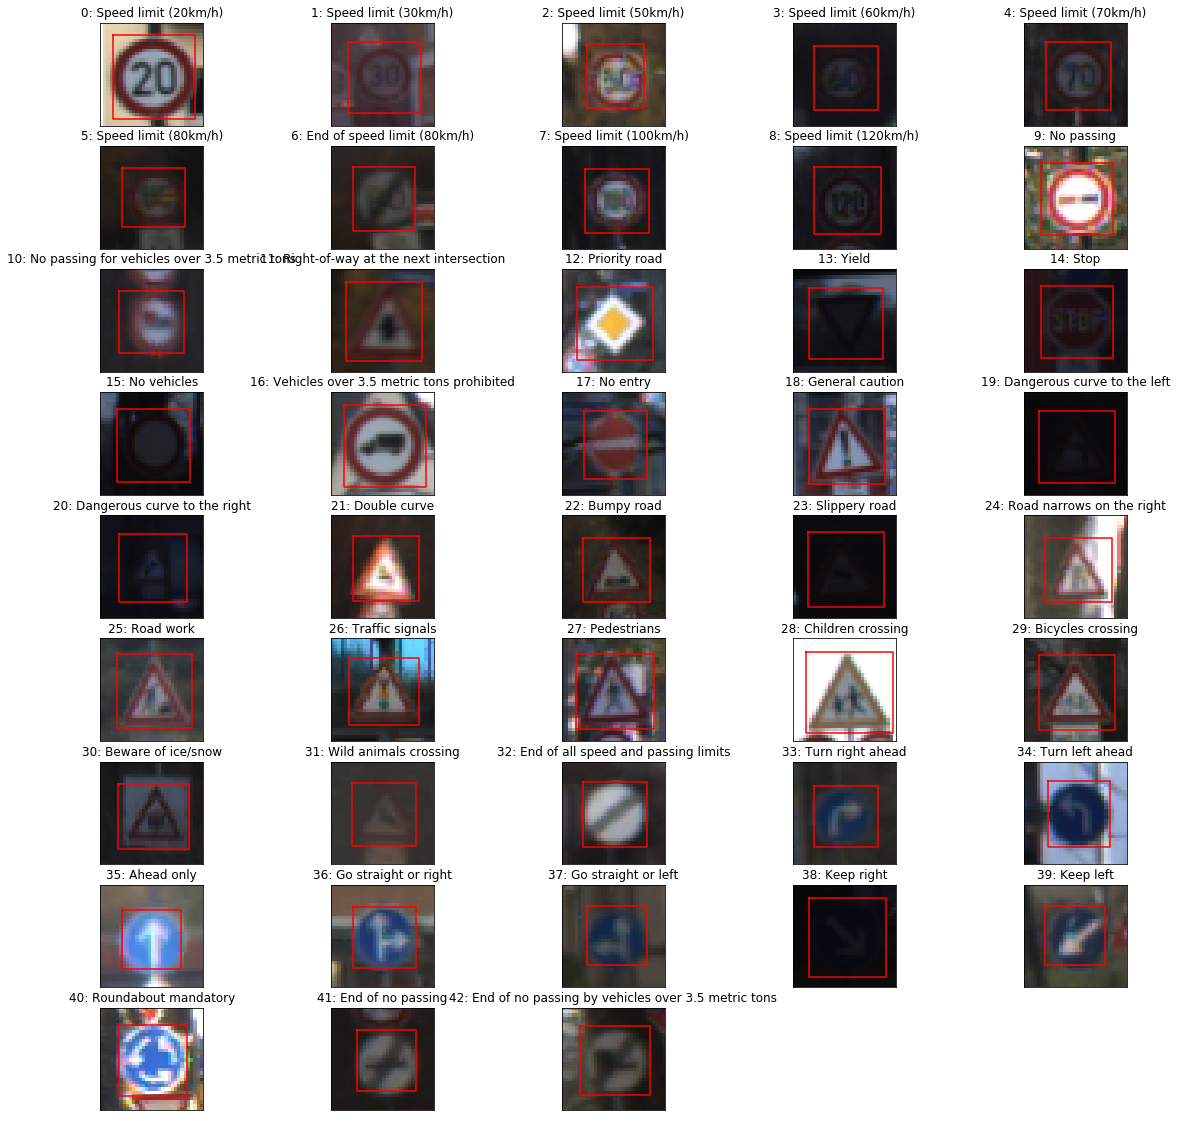

In [8]:
visualize_dataset(sample_dataset_by_uniq_classes(train_dataset))

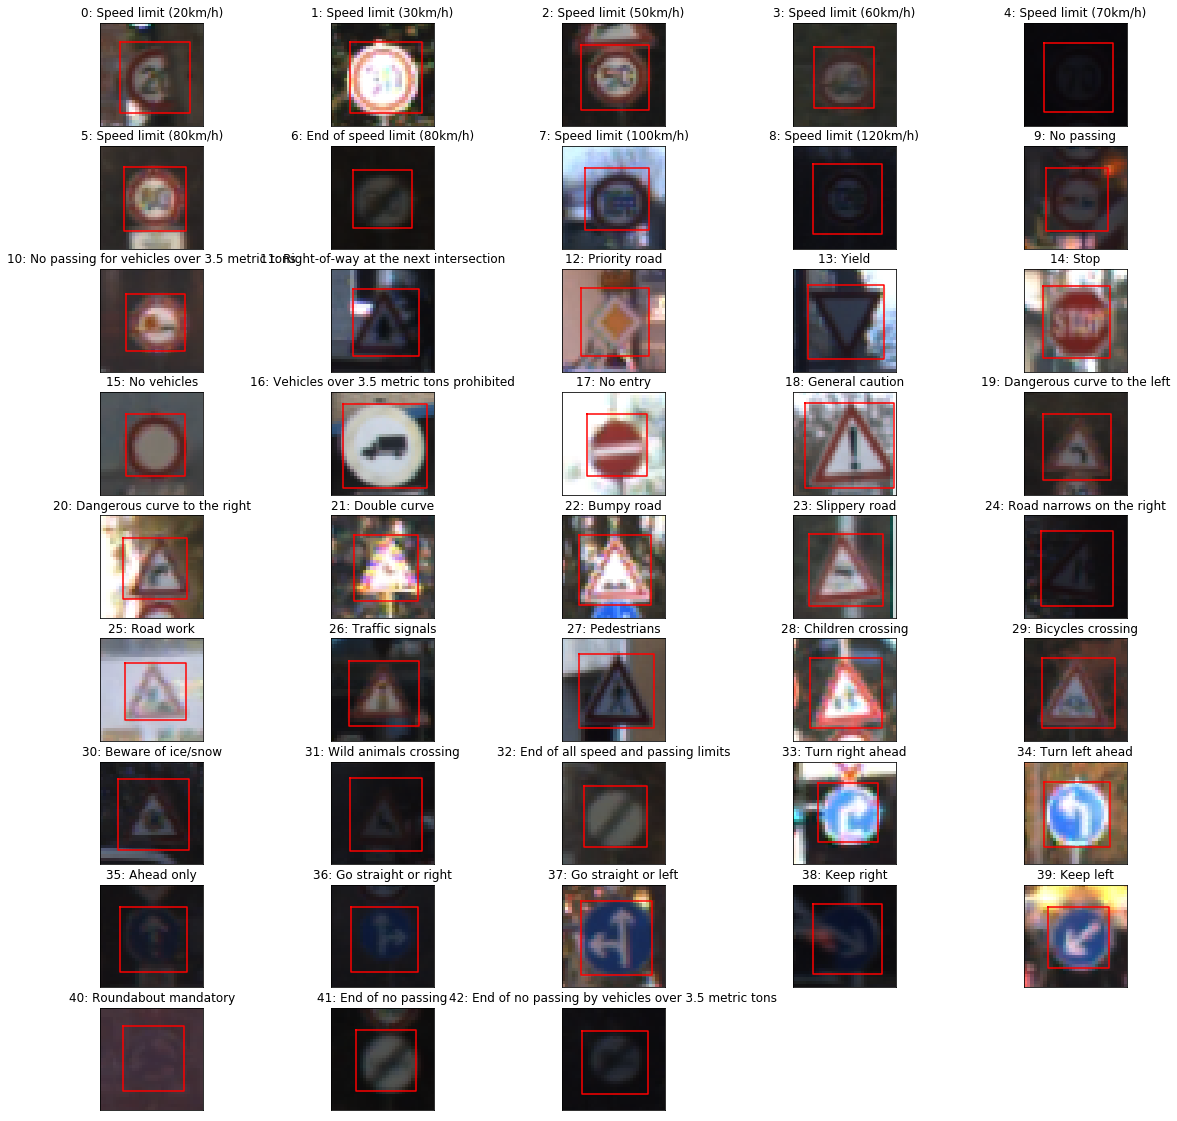

In [9]:
visualize_dataset(sample_dataset_by_uniq_classes(valid_dataset))

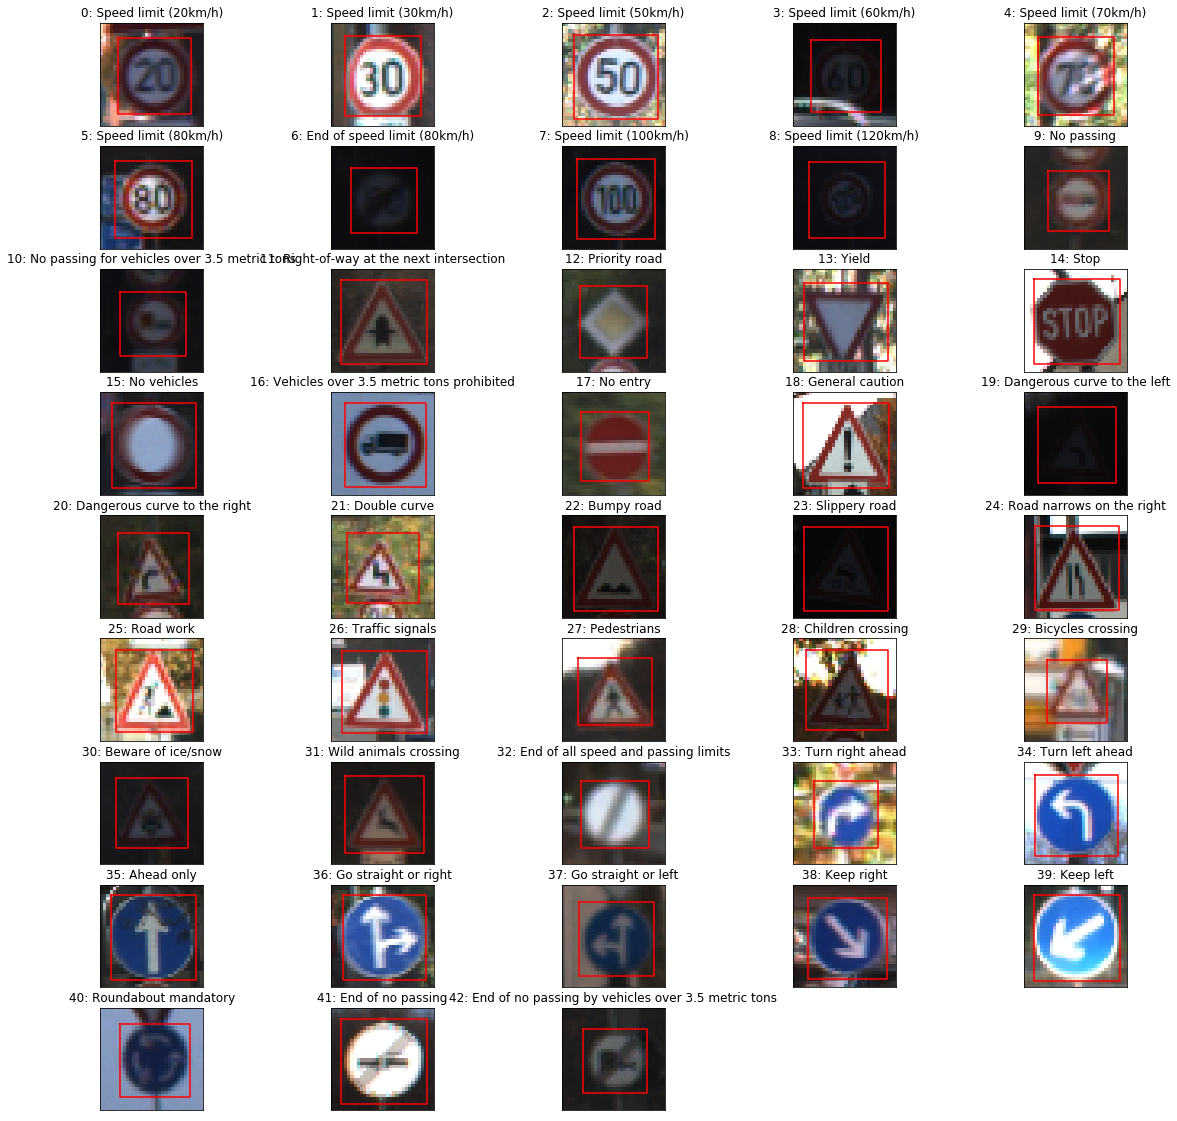

In [10]:
visualize_dataset(sample_dataset_by_uniq_classes(test_dataset))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
import cv2
import numpy as np

def pre_proc_images_gray(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).reshape(image_dim, image_dim, 1) for img in images])

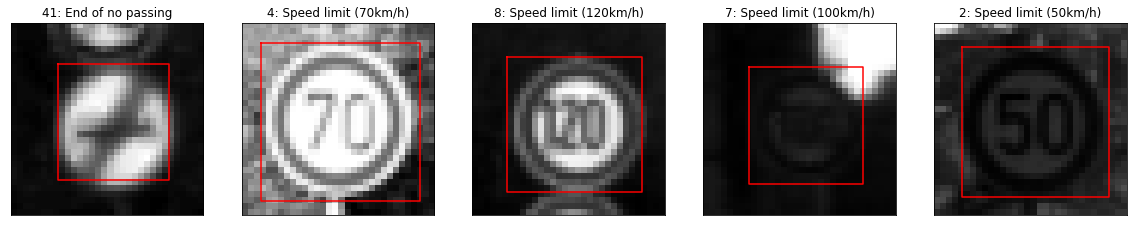

In [12]:
temp_dataset = sample_dataset_by_interval(train_dataset, 8000)
temp_dataset['features'] = pre_proc_images_gray(temp_dataset['features'])[:,:,:,0]
visualize_dataset(temp_dataset, cmap='gray')

In [14]:
def pre_proc_images_normalize(images):
    return (images.astype(np.float32) - 128) / 128

255 0 0.992188 -0.898438


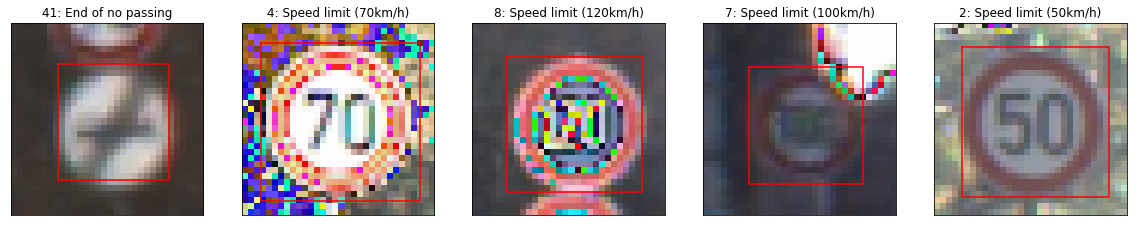

In [14]:
temp_dataset = sample_dataset_by_interval(train_dataset, 8000)
temp_dataset['features'] = pre_proc_images_normalize(temp_dataset['features'])
print(train_dataset['features'].max(), train_dataset['features'].min(), temp_dataset['features'].max(), temp_dataset['features'].min())
visualize_dataset(temp_dataset, vmin=-1.0, vmax=1.0)

In [23]:
def generate_images_noise(images):
    return np.random.normal(scale=0.04, size=images.shape) + images

255 0 1.11436636838 -0.96206284753


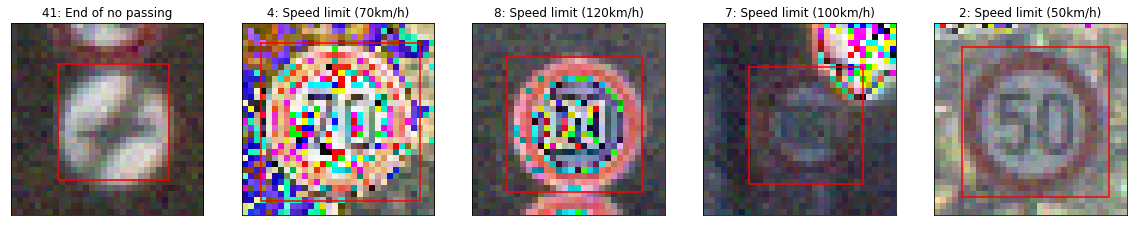

In [16]:
# Visualize by normalizing first, then adding noise.

temp_dataset = sample_dataset_by_interval(train_dataset, 8000)
temp_dataset['features'] = generate_images_noise(pre_proc_images_normalize(temp_dataset['features']))
print(train_dataset['features'].max(), train_dataset['features'].min(), temp_dataset['features'].max(), temp_dataset['features'].min())
visualize_dataset(temp_dataset, vmin=0-1, vmax=255+1)

In [17]:
def crop_coords_deterministic(s, c):
    """Returns coords for cropping images exactly at the boundary.
    We don't want to generate by cropping at the boundary b/c that's deterministic.
    Use this for verification of math only."""
    
    w, h = s
    x1, y1, x2, y2 = c
    x1, x2 = float(x1) / w * image_dim, float(x2) / w * image_dim
    y1, y2 = float(y1) / h * image_dim, float(y2) / h * image_dim
    return math.floor(x1), math.ceil(x2)+1, math.floor(y1), math.ceil(y2)+1

def crop_coords_rand(s, c):
    x1, x2, y1, y2 = crop_coords_deterministic(s, c)
    
    x1 = np.random.randint(x1 + 1)
    y1 = np.random.randint(y1 + 1)
    
    x2 = np.random.randint(image_dim - x2 + 2) + x2
    y2 = np.random.randint(image_dim - y2 + 2) + y2
    
    return x1, x2, y1, y2

def generate_images_crop(dataset, coords_fn=crop_coords_rand):
    result_dataset = {
        'features': [],
        'labels': []
    }
    for f, l, s, c in zip(dataset['features'], dataset['labels'], dataset['sizes'], dataset['coords']):
        x1, x2, y1, y2 = coords_fn(s, c)
        cropped = f[x1:x2, y1:y2, :]
        cropped = cv2.resize(cropped, (image_dim, image_dim))
        
        result_dataset['features'].append(cropped)
        result_dataset['labels'].append(l)
    return result_dataset

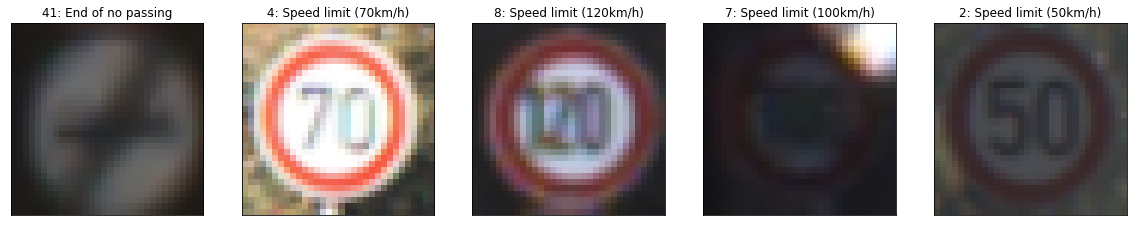

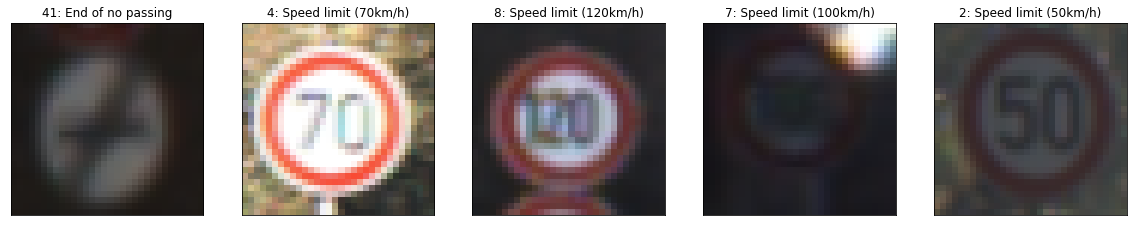

In [18]:
temp_dataset = sample_dataset_by_interval(train_dataset, 8000)
visualize_dataset(generate_images_crop(temp_dataset, coords_fn=crop_coords_deterministic))
visualize_dataset(generate_images_crop(temp_dataset))

In [19]:
def rand_pad_pixels():
    return np.random.randint(0, image_dim / 2, size=2)

def generate_images_distort(dataset):
    result_dataset = {
        'features': [],
        'labels': []
    }
    for f, l in zip(dataset['features'], dataset['labels']):
        distorted = np.pad(f, (rand_pad_pixels(), rand_pad_pixels(), (0,0)), 'constant')
        distorted = cv2.resize(distorted, (image_dim, image_dim))
        
        result_dataset['features'].append(distorted)
        result_dataset['labels'].append(l)
    return result_dataset

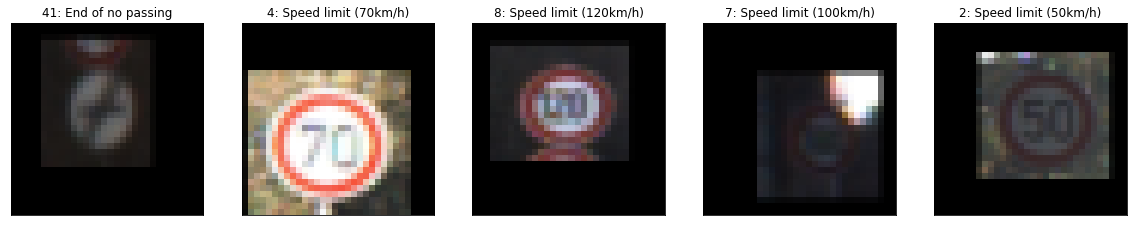

In [20]:
temp_dataset = sample_dataset_by_interval(train_dataset, 8000)
visualize_dataset(generate_images_distort(temp_dataset))

In [15]:
def pre_proc_images(images):
    return pre_proc_images_normalize(pre_proc_images_gray(images))

def generation_sampling(class_id):
    num_samples_largest_class = distro_classes.max()
    
    # we'll generate this many images per one input
    generator_ratio = len([
            generate_images_crop,
            generate_images_distort
        ])

    # we want to generate for at least this portion of the raw dataset, even for the most populous class
    min_sampling = 0.01

    # the most populous class will have this many images in total
    target_num_samples = num_samples_largest_class * (1 + min_sampling * generator_ratio)
    
    # current class should have this many images generated
    target_num_generated = target_num_samples - distro_classes[class_id]
    
    # current class should sample this much portion and pass it to generation
    target_sampling = target_num_generated / distro_classes[class_id] / generator_ratio
    
    return max(target_sampling, min_sampling)

def multiply_dataset(dataset_one_class, class_id):
    '''Modifies `dataset_one_class` in-place.'''

    sampling = generation_sampling(class_id)
    num_repetition = math.floor(sampling)
    num_remainder = math.floor(len(dataset_one_class['labels']) * (sampling - num_repetition))
    
    for k in ['features', 'labels', 'sizes', 'coords']:
        sampled = np.concatenate((
                np.repeat(dataset_one_class[k], num_repetition, axis=0),
                dataset_one_class[k][0:num_remainder]
            ))
        dataset_one_class[k] = sampled

def generate_images_proportionally(dataset):
    result = {}
    for k in ['features', 'labels']:
        result[k] = dataset[k]
    
    for class_id in uniq_classes:
        indexes = dataset['labels'] == class_id
        dataset_one_class = {}
        for k in ['features', 'labels', 'sizes', 'coords']:
            dataset_one_class[k] = dataset[k][indexes]
        
        multiply_dataset(dataset_one_class, class_id)
        
        for generator in [generate_images_crop, generate_images_distort]:
            dataset_generated = generator(dataset_one_class)
            for k in ['features', 'labels']:
                result[k] = np.concatenate((result[k], dataset_generated[k]))

    return result

def pre_proc_and_generate_training_images():
    gen_ds = generate_images_proportionally(train_dataset)
    
    x = gen_ds['features']
    y = gen_ds['labels']

    x = pre_proc_images(x)
    
    # generating noise is too exensive for rgb, so do it after grayscale pre-processing
    gen_x = generate_images_noise(x)
    x = np.concatenate((x, gen_x))
    y = np.concatenate((y, y))
    
    return x, y

In [22]:
X_train, y_train = pre_proc_and_generate_training_images()
# X_train, y_train = pre_proc_images(train_dataset['features']), train_dataset['labels'] # for debug
print(train_dataset['features'].shape, X_train.shape, train_dataset['labels'].shape, y_train.shape)

X_valid = pre_proc_images(valid_dataset['features'])
y_valid = valid_dataset['labels']
print(X_valid.shape, y_valid.shape)

X_test = pre_proc_images(test_dataset['features'])
y_test = test_dataset['labels']
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (176298, 32, 32, 1) (34799,) (176298,)
(4410, 32, 32, 1) (4410,)
(12630, 32, 32, 1) (12630,)


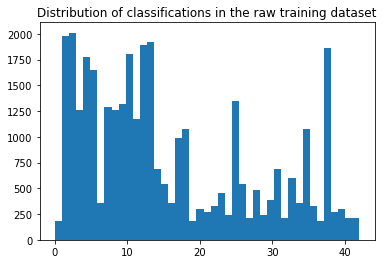

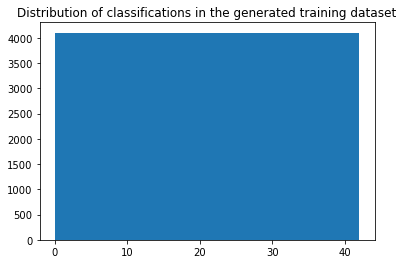

In [23]:
plt.hist(train_dataset['labels'], bins=n_classes)
plt.title('Distribution of classifications in the raw training dataset')

plt.figure()
foo = plt.hist(y_train, bins=n_classes)
plt.title('Distribution of classifications in the generated training dataset')

In [24]:
# free up memory. or just restart notebook kernel after dumping below.

del temp_dataset
del train_dataset, valid_dataset, test_dataset

In [25]:
with open('processed_samples.p', 'wb') as f:
    samples = (X_train, y_train, X_valid, y_valid, X_test, y_test)
    pickle.dump(samples, f)

### Notebook checkpoint. Reload processed samples here.

In [1]:
import pickle

with open('processed_samples.p', 'rb') as f:
    X_train, y_train, X_valid, y_valid, X_test, y_test = pickle.load(f)

In [2]:
n_train = len(y_train)

uniq_classes = set(y_train) | set(y_valid) | set(y_test)

n_classes = len(uniq_classes)

image_dim = X_train.shape[1]
image_depth = X_train.shape[-1]

print(n_train, uniq_classes, n_classes, image_dim, image_depth)

176298 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42} 43 32 1


### Model Architecture

In [3]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

In [4]:
def conv2d(x, W_shape, mean, stddev, strides=1, padding='VALID'):
    W = tf.Variable(tf.truncated_normal(shape=W_shape, mean=mean, stddev=stddev))
    b = tf.Variable(tf.zeros(W_shape[-1]))
    
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x), W, b

def maxpool2d(x, k=2, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)

def fully_connected(layer_in, layer_in_size, layer_out_size, mean, stddev, do_activate=True):
    W = tf.Variable(tf.truncated_normal(shape=(layer_in_size, layer_out_size), mean=mean, stddev=stddev))
    b = tf.Variable(tf.zeros(layer_out_size))
    
    layer_out = tf.matmul(layer_in, W) + b
    if do_activate:
        return tf.nn.relu(layer_out), W, b
    else:
        return layer_out, W, b

def conv_net(x, keep_prob):
    mu = 0
    sigma = 0.1
    
    conv1, conv1_W, conv1_b = conv2d(x, (5, 5, image_depth, 6), mu, sigma)
    conv1 = maxpool2d(conv1)

    conv2, conv2_W, conv2_b = conv2d(conv1, (5, 5, 6, 16), mu, sigma)
    conv2 = maxpool2d(conv2)

    fc0 = flatten(conv2)
    
    fc1, fc1_W, fc1_b = fully_connected(fc0, 400, 120, mu, sigma)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    fc2, fc2_W, fc2_b = fully_connected(fc1, 120, 84, mu, sigma)

    logits, logits_W, logits_b = fully_connected(fc2, 84, n_classes, mu, sigma, do_activate=False)
    
    return logits, [conv1_W, conv2_W, fc1_W, fc2_W, logits_W], [conv1, conv2, fc1, fc2]

x_placeholder = tf.placeholder(tf.float32, (None, image_dim, image_dim, image_depth))

keep_prob_placeholder = tf.placeholder(tf.float32)

logits, all_weights, all_layers = conv_net(x_placeholder, keep_prob_placeholder)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [5]:
l2_rate = 0.0001 # (lambda / n)

def train_operation(logits, y, learning_rate):
    cross_entropy_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y))
    
    l2_cost = tf.constant(0, dtype=tf.float32)
    for w in all_weights:
        l2_cost += tf.nn.l2_loss(w)
    l2_cost = l2_rate * l2_cost
    
    cost = cross_entropy_cost + l2_cost
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    return optimizer.minimize(cost)

def accuracy_operation(logits, y):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_placeholder = tf.placeholder(tf.int32, (None))
y_onehot = tf.one_hot(y_placeholder, n_classes)

learning_rate_placeholder = tf.placeholder(tf.float32)

train_op = train_operation(logits, y_onehot, learning_rate_placeholder)
accuracy_op = accuracy_operation(logits, y_onehot)

In [6]:
import numpy as np

BATCH_SIZE = 128

def run_in_batches(sess, op, X_data, y_data):
    batch_sizes = []
    results = []
    for offset in range(0, len(X_data), BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        result = sess.run(op, feed_dict={
                x_placeholder: batch_x,
                y_placeholder: batch_y,
                keep_prob_placeholder: 1.0
            })
        
        batch_sizes.append(len(batch_y))
        results.append(result)
    return batch_sizes, results

def run_accuracy_op(sess, X_data, y_data):
    batch_sizes, results = run_in_batches(sess, accuracy_op, X_data, y_data)
    
    return np.sum(np.multiply(batch_sizes, results)) / len(X_data)

In [7]:
saver = tf.train.Saver()

In [14]:
keep_prob_while_training = 0.5

epochs = 20

def learning_rate_schedule(epoch):
    if epoch <= 5:
        return 0.002
    if epoch <= 10:
        return 0.001
    return 0.0005

def run_train_op(resume=False):
    train_accuracies = []
    valid_accuracies = []
    
    with tf.Session() as sess:
        if resume:
            saver.restore(sess, saver_path)
        else:
            sess.run(tf.global_variables_initializer())
        
        for i in range(epochs):
            ep = i + 1

            X_shuffled, y_shuffled = shuffle(X_train, y_train)
            for offset in range(0, n_train, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_shuffled[offset:end], y_shuffled[offset:end]
                sess.run(train_op, feed_dict={
                        x_placeholder: batch_x,
                        y_placeholder: batch_y,
                        keep_prob_placeholder: keep_prob_while_training,
                        learning_rate_placeholder: learning_rate_schedule(ep)
                    })
            
            if ep >= 6:
                saver.save(sess, 'sess_epoch{}'.format(ep))
            
            train_accuracy = run_accuracy_op(sess, X_train, y_train)
            valid_accuracy = run_accuracy_op(sess, X_valid, y_valid)
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)
            print("EPOCH {}: Training Accuracy = {:.3f}, Validation Accuracy = {:.3f}"
                  .format(ep, train_accuracy, valid_accuracy))
        
    return train_accuracies, valid_accuracies

train_accuracies, valid_accuracies = run_train_op()

EPOCH 1: Training Accuracy = 0.810, Validation Accuracy = 0.908
EPOCH 2: Training Accuracy = 0.871, Validation Accuracy = 0.942
EPOCH 3: Training Accuracy = 0.892, Validation Accuracy = 0.961
EPOCH 4: Training Accuracy = 0.903, Validation Accuracy = 0.953
EPOCH 5: Training Accuracy = 0.916, Validation Accuracy = 0.969
EPOCH 6: Training Accuracy = 0.930, Validation Accuracy = 0.959
EPOCH 7: Training Accuracy = 0.939, Validation Accuracy = 0.967
EPOCH 8: Training Accuracy = 0.943, Validation Accuracy = 0.975
EPOCH 9: Training Accuracy = 0.947, Validation Accuracy = 0.971
EPOCH 10: Training Accuracy = 0.947, Validation Accuracy = 0.966
EPOCH 11: Training Accuracy = 0.953, Validation Accuracy = 0.974
EPOCH 12: Training Accuracy = 0.956, Validation Accuracy = 0.968
EPOCH 13: Training Accuracy = 0.957, Validation Accuracy = 0.974
EPOCH 14: Training Accuracy = 0.959, Validation Accuracy = 0.974
EPOCH 15: Training Accuracy = 0.960, Validation Accuracy = 0.972
EPOCH 16: Training Accuracy = 0.96

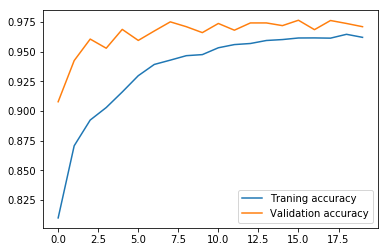

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_accuracies, label = 'Traning accuracy')
plt.plot(valid_accuracies, label = 'Validation accuracy')
plt.legend()

In [8]:
best_sess_checkpoint = './sess_epoch11'

In [17]:
with tf.Session() as sess:
    saver.restore(sess, best_sess_checkpoint)
    test_acc = run_accuracy_op(sess, X_test, y_test)
    print('Test Accuracy = {:.3f}'.format(test_acc))

Test Accuracy = 0.954


In [9]:
import numpy as np

def get_yhats():
    with tf.Session() as sess:
        saver.restore(sess, best_sess_checkpoint)

        top_1_tensor = tf.nn.top_k(logits)

        _, top_1_results = run_in_batches(sess, top_1_tensor, X_test, y_test)

    top_1_values = []
    for top_1_result in top_1_results:
        top_1_values.extend(top_1_result.indices)

    return np.reshape(top_1_values, -1)

def get_precision_and_recall(ys, yhats):
    precision_and_recall = []
    wrongs = []
    
    for class_id in sorted(uniq_classes):
        desired_positives_inds = ys == class_id
        desired_positives_yhats = yhats[desired_positives_inds]
        true_positives_inds = desired_positives_yhats == class_id
        num_true_positives = np.count_nonzero(true_positives_inds)
        num_false_negatives = len(desired_positives_yhats) - num_true_positives
        false_negatives = desired_positives_yhats[np.invert(true_positives_inds)]
        assert num_false_negatives == len(false_negatives)
        
        
        predicted_positives_inds = yhats == class_id
        predicted_positives_ys = ys[predicted_positives_inds]
        true_positives_inds_alt = predicted_positives_ys == class_id
        num_true_positives_alt = np.count_nonzero(true_positives_inds_alt)
        assert num_true_positives_alt == num_true_positives
        num_false_positives = len(predicted_positives_ys) - num_true_positives
        false_positives = predicted_positives_ys[np.invert(true_positives_inds_alt)]
        assert num_false_positives == len(false_positives)
        
        precision = num_true_positives / (num_true_positives + num_false_positives)
        recall = num_true_positives / (num_true_positives + num_false_negatives)
        
        precision_and_recall.append([
                class_id,
                precision, recall,
                num_true_positives, num_false_negatives, num_false_positives
            ])
        
        wrongs.append([class_id, false_negatives, false_positives])
    
    return np.array(precision_and_recall), wrongs

yhats = get_yhats()
precision_and_recall, wrongs = get_precision_and_recall(y_test, yhats)

assert np.sum(precision_and_recall[:, [3,4]]) == len(y_test)
assert np.sum(precision_and_recall[:, [3,5]]) == len(y_test)

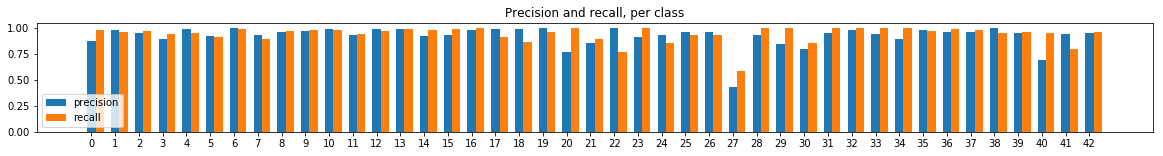

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

width = 0.35
plt.figure(figsize=(20, 2))
ax0 = plt.bar(precision_and_recall[:, 0], precision_and_recall[:, 1], width)
ax1 = plt.bar(precision_and_recall[:, 0] + width, precision_and_recall[:, 2], width)
plt.legend([ax0, ax1], ['precision', 'recall'], loc=3)
plt.xticks(precision_and_recall[:, 0])
plt.title('Precision and recall, per class')
None

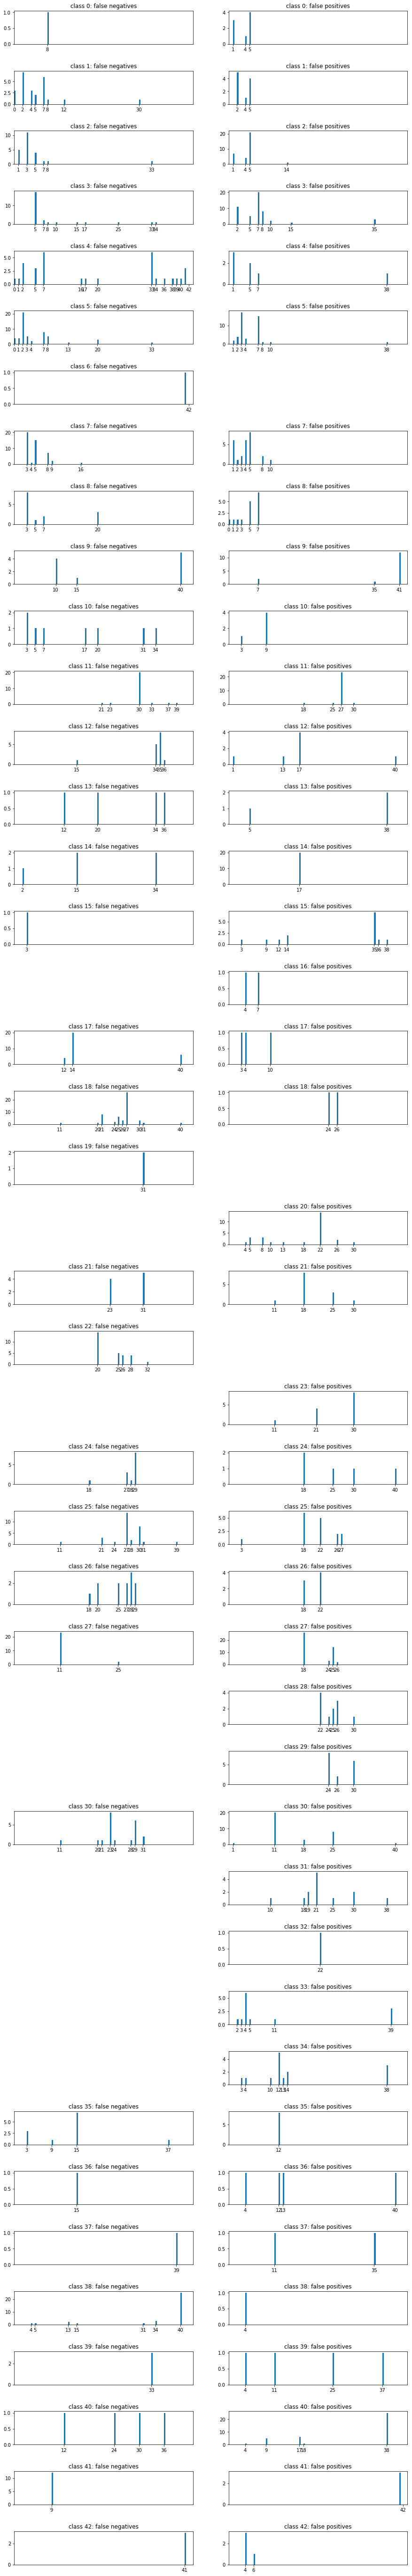

In [11]:
fig, axes = plt.subplots(nrows=len(wrongs), ncols=2, figsize=(15, 100), gridspec_kw = {'hspace':0.8})

for (class_id, false_negatives, false_positives), axlr in zip(wrongs, axes):
    for data, ax, descr in zip([false_negatives, false_positives], axlr, ['false negatives', 'false positives']):
        if len(data) > 0:
            ax.hist(data, bins=range(n_classes), width=0.35)
            ax.set_title('class {}: {}'.format(class_id, descr))
            ax.set_xlim([0, n_classes])
            ax.set_xticks(list(set(data)))
        else:
            ax.remove()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

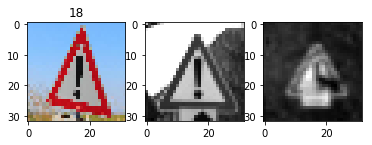

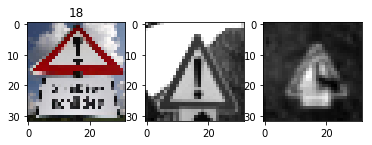

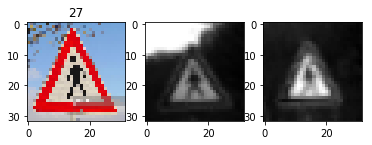

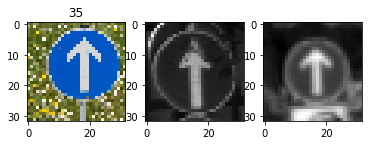

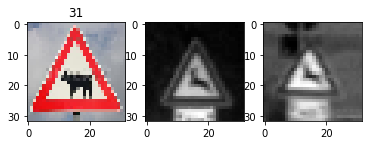

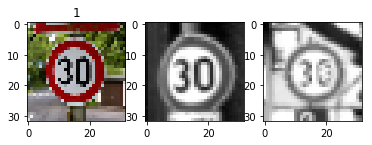

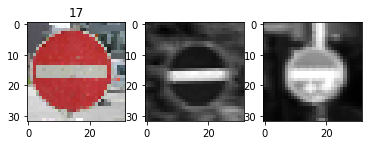

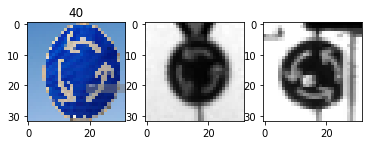

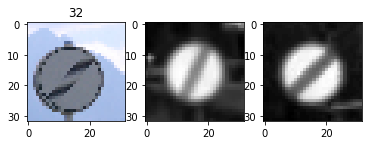

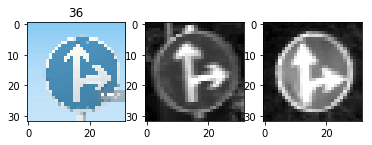

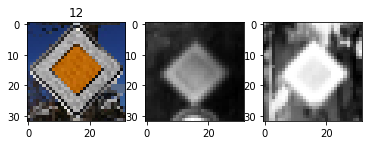

In [12]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_images_extra_path = './test_images_extra/'

X_test_extra = []
y_test_extra = []

for image_in_name in os.listdir(test_images_extra_path):
    img_in_path = test_images_extra_path + image_in_name
    img_in = cv2.imread(img_in_path)[:,:,::-1]
    img_in = cv2.resize(img_in, (image_dim, image_dim))
    X_test_extra.append(img_in)
    
    img_class = int(re.match(r'^\d+', image_in_name).group())
    y_test_extra.append(img_class)
    
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_in)
    plt.title(img_class)
    
    temp_f = X_test[y_test == img_class]

    plt.subplot(132)
    plt.imshow(temp_f[0][:,:,0], cmap='gray')
    plt.subplot(133)
    plt.imshow(temp_f[-1][:,:,0], cmap='gray')

X_test_extra = np.array(X_test_extra)
y_test_extra = np.array(y_test_extra)

### Predict the Sign Type for Each Image

see below

### Analyze Performance

see below

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [16]:
X_test_extra_pp = pre_proc_images(X_test_extra)

logits_top = tf.nn.top_k(logits, 6)

with tf.Session() as sess:
    saver.restore(sess, best_sess_checkpoint)
    predictions, acc = sess.run([logits_top, accuracy_op], feed_dict={
            x_placeholder: X_test_extra_pp,
            y_placeholder: y_test_extra,
            keep_prob_placeholder: 1.0
        })

for y, pcts, yhats in zip(y_test_extra, predictions.values, predictions.indices):
    pred_summary = []
    for pct, yhat in zip(pcts, yhats):
        pred_summary.append('{:>2} ({:4.1f}%) '.format(yhat, pct))
    pred_summary = ''.join(pred_summary)
    
    print('label = {:>2}, correct = {:b}, predictions = {}'.format(y, y == yhats[0], pred_summary))

print('accuracy = {:.3f}'.format(acc))

label = 18, correct = 1, predictions = 18 (58.6%) 27 (31.5%) 26 (29.6%) 24 (19.8%) 31 (14.8%) 21 (12.8%) 
label = 18, correct = 0, predictions =  9 (28.3%) 17 (25.7%) 41 (20.8%) 14 (15.7%) 16 (14.7%) 12 ( 8.3%) 
label = 27, correct = 1, predictions = 27 (53.4%) 24 (37.8%) 18 (36.2%) 26 (26.0%) 11 (25.2%) 28 (18.6%) 
label = 35, correct = 1, predictions = 35 (28.7%) 37 (14.3%)  9 (10.3%)  3 ( 3.7%) 33 ( 3.4%) 15 ( 2.1%) 
label = 31, correct = 0, predictions = 19 (37.8%) 23 (36.2%) 11 (23.0%) 21 (22.5%) 31 (18.0%) 30 (15.1%) 
label =  1, correct = 1, predictions =  1 (17.9%)  0 (12.4%)  4 ( 9.5%)  7 ( 9.3%)  2 ( 5.6%) 40 ( 2.3%) 
label = 17, correct = 1, predictions = 17 (33.1%) 14 (13.1%) 16 ( 7.1%) 12 ( 6.4%)  9 ( 5.9%) 37 ( 5.3%) 
label = 40, correct = 1, predictions = 40 (19.6%) 12 (15.9%) 42 ( 3.9%) 32 ( 3.4%) 14 ( 1.8%)  7 ( 0.6%) 
label = 32, correct = 1, predictions = 32 ( 8.8%) 39 ( 5.0%) 16 ( 4.3%) 41 ( 4.2%)  0 ( 3.1%) 14 ( 2.8%) 
label = 36, correct = 1, predictions = 36 (20.

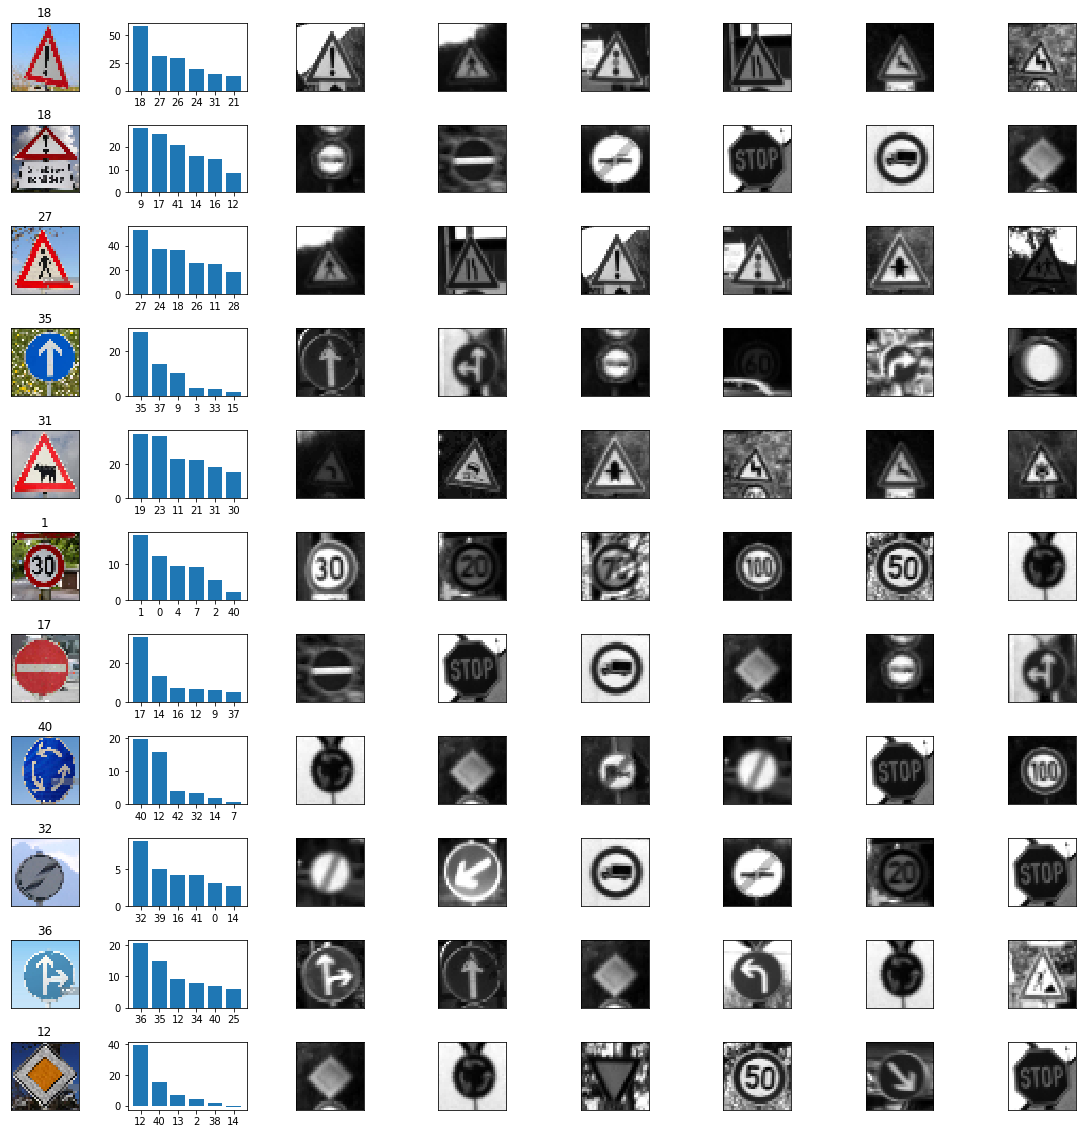

In [17]:
reference_images = {}
for y in set(y_test_extra) | set(predictions.indices.flatten()):
    reference_images[y] = X_test[y_test == y][0]

_fig, axes = plt.subplots(nrows=len(y_test_extra), ncols=1+1+6, figsize=(20,20), gridspec_kw = {'wspace':0.2, 'hspace':0.5})
for img, y, pcts, yhats, (aximg, axbar, *axrefs) in zip(X_test_extra, y_test_extra, predictions.values, predictions.indices, axes):
    aximg.imshow(img)
    aximg.get_xaxis().set_visible(False)
    aximg.get_yaxis().set_visible(False)
    aximg.set_title(y)
    
    axbar.bar(range(len(pcts)), pcts)
    axbar.set_xticks(range(len(pcts)))
    axbar.set_xticklabels(yhats)

    for yhat, ax in zip(yhats, axrefs):
        img_ref = reference_images[yhat]
        img_ref = img_ref.reshape(*img.shape[0:2])
        ax.imshow(img_ref, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [50]:
def visualize_convolution_output(sess, layer_tensor, X_data, title, **imshow_options):
    activation = sess.run(layer_tensor, feed_dict={x_placeholder: X_data})
    
    activation = activation[0] # visualize for just the first input.
    
    num_fms = activation.shape[-1]
    
    fig, axes = plt.subplots(ncols=num_fms, figsize=(10, 1))
    fig.suptitle(title)
    
    for fm_ind, ax in zip(range(num_fms), axes):
        ax.imshow(activation[:,:,fm_ind], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

def visualize_convolution_outputs(X_datum):
    with tf.Session() as sess:
        saver.restore(sess, best_sess_checkpoint)
        
        X_data = [X_datum] # a batch of one input.
        
        conv_layers = all_layers[0:2] # two conv layers
        
        titles = ['layer {}'.format(i + 1) for i in range(len(conv_layers))]
        
        for layer, title in zip(conv_layers, titles):
            visualize_convolution_output(sess, layer, X_data, title)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


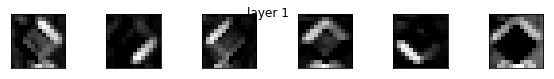

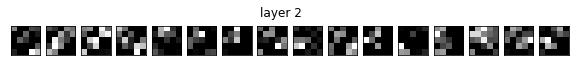

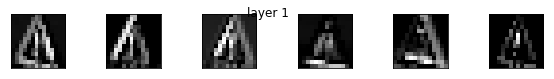

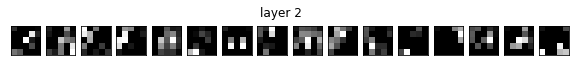

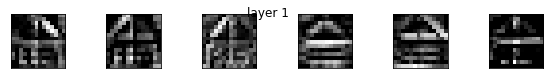

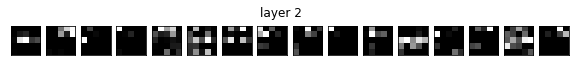

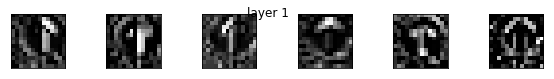

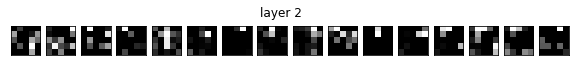

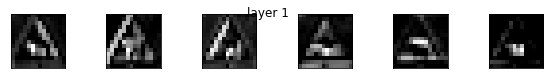

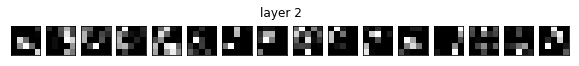

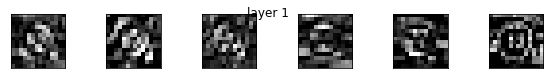

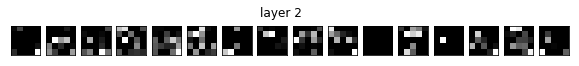

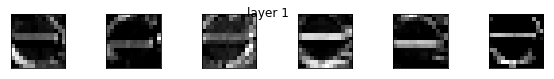

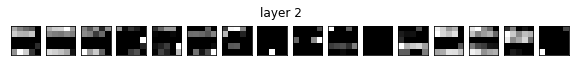

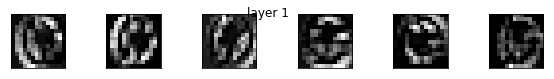

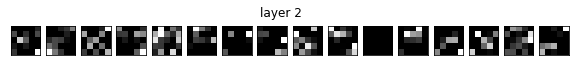

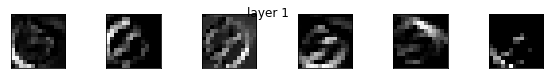

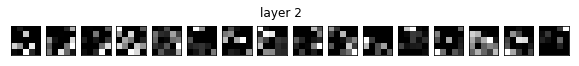

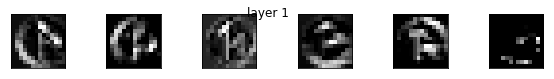

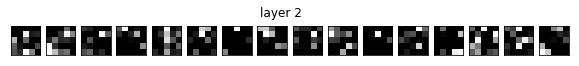

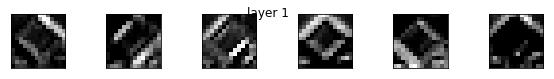

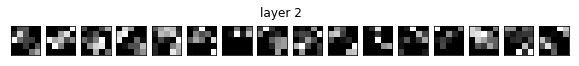

In [52]:
visualize_convolution_outputs(reference_images[12])
for X_datum in X_test_extra_pp:
    visualize_convolution_outputs(X_datum)

In [18]:
def visualize_feature_map(sess, weight_tensor, title, **imshow_options):
    fms = sess.run(weight_tensor)

    # numbers of output and input feature maps
    num_fm_in = fms.shape[-2]
    num_fm_out = fms.shape[-1]
    
    fig, axes = plt.subplots(nrows=num_fm_in, ncols=num_fm_out, figsize=(10, 5))
    axes = axes.reshape(num_fm_in, num_fm_out) # force 2d when num rows or num cols is 1
    fig.suptitle(title)

    for fmi in range(num_fm_in):
        for fmo in range(num_fm_out):
            ax = axes[fmi][fmo]
            ax.imshow(fms[:,:,fmi,fmo], interpolation="nearest", cmap="gray", **imshow_options)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

def visualize_feature_maps():
    with tf.Session() as sess:
        saver.restore(sess, best_sess_checkpoint)

        conv_weights = all_weights[0:2] # two conv layers
        
        titles = ['layer {}'.format(i + 1) for i in range(len(conv_weights))]
        
        for w, title in zip(conv_weights, titles):
            visualize_feature_map(sess, w, title)

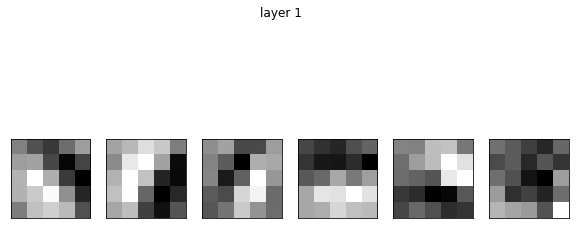

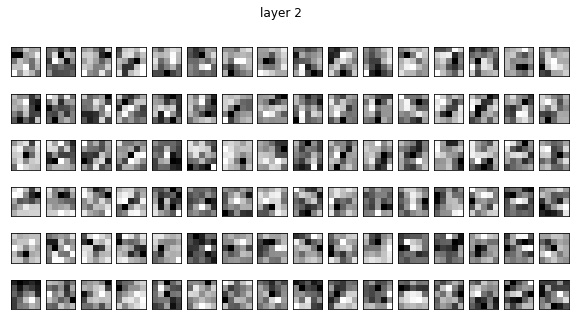

In [19]:
visualize_feature_maps()